<h1 style="text-align:center">Git Hub Bug Prediction</h1>


This work demonstrates the implementation of static semantic word embedding techniques like Word2Vec, Glove and FastText and the performance analysis is carried here using Word2Vec baseline for statistical Machine Learning models. I have also implemented and analyzed non-semantic word embedding techniques like BOW and TFIDF. This is my 2nd notebook in the end-to-end implementation approach for solving GitHub Bug Prediction problem series. You can also refer my [1st](http://www.kaggle.com/gauravharamkar/eda-github-bug-prediction) notebook from this series where I have carried out detailed EDA for this problem.

# **Table of contents**

1. Problem Statement
2. Import Libraries and Data
3. Dataset Analysis
4. Data Preprocessing
5. Data transformation - Word Embeddings
    * Non-Semantic Embeddings
        * Bag of Words (BOW)
        * TF-IDF 
    * Static Semantic Embeddings 
        * Word2Vec
        * Glove
        * FastText
6. Defining methods for Document to Vector conversion and Statistical Modelling and Evaluation
    * Word Vectors to Sentence conversion using average word2vec embedding
    * Word Vectors to Sentence conversion using Tf-Idf weighted word2vec embeddings
    * Statistical Models Building and Evaluation using word2vec embeddings
7. Model Building and Evaluation using Statical Models
8. Model Building and Evaluation using Neural Network LSTM based model
9. Conclusion

## 1. Problem Statement :
<p> For an issue posted on the GitHub, predict whether that issue is a bug or a feature or a question based on the issue title and the body text.</p> 

## 2. Import Libraries and Data

In [ ]:
# fix for autocomplete intellisense
#%config Completer.use_jedi = False

#for printing all the outputs of a cell in the same output window
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"


# Basic Libraries

import numpy as np
import pandas as pd
import pandas_profiling
import re
import string
import random
import math
import time
import json
import os
from os import listdir
import itertools
import collections
from collections import Counter, defaultdict
from tqdm import tqdm
from sklearn import utils


# Visualization

# matplotlib
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# seaborn
import seaborn as sns
sns.set_style(style='whitegrid')

# plotly
!pip3 install chart_studio
import chart_studio.plotly as py

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import plotly.express as px
import plotly.graph_objs as go
from plotly import tools

# cufflinks
!pip3 install cufflinks
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# nltk wordcloud
from wordcloud import WordCloud,STOPWORDS

# dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.manifold import TSNE



# Preprocessing
!pip3 install beautifulsoup4
from bs4 import BeautifulSoup

import nltk
import spacy

from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

nlp_spcy = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = list(set(STOP_WORDS))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score,  cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

# from imblearn.over_sampling import ADASYN, SMOTE
# from imblearn.under_sampling import NearMiss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm


# Gensim models
from smart_open import open
from gensim.models import Word2Vec, FastText, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
#from gensim.models.fasttext import load_facebook_vectors
#from gensim.models.fasttext import load_facebook_model


# Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import  accuracy_score, log_loss, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.pipeline import make_pipeline
from lime import lime_text
from lime.lime_text import LimeTextExplainer


# model serialization
import pickle


# Suppress warnings 
import warnings
warnings.filterwarnings(action = "ignore")


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()


## for deep learning

##% tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.models import Sequential
from keras import models, layers, preprocessing as KP
from keras.layers.embeddings import Embedding
from keras import backend as KB

## for bert language model
# import transformers

### Load the Dataset

In [ ]:
train_df = pd.read_json('../input/github-bugs-prediction/embold_train.json')
print("Train Dataframe:")
train_df.head(3)
print(f'Train dataframe contains {train_df.shape[0]} samples.')
print('Number of features in train data : ', train_df.shape[1])
print('Train Features : ', train_df.columns.values)

### Load the Extra Train data

In [ ]:
train_extra_df = pd.read_json('../input/github-bugs-prediction/embold_train_extra.json')
train_extra_df.head()
print('')
print(f'Extra train dataset contains {train_extra_df.shape[0]} samples.')
print('Number of features in the extra train dataset : ', train_extra_df.shape[1])
print('Features in the extra train dataset : ', train_extra_df.columns.values)

### Inference:

- Extra train data contains twice the number of data point compared to original train data.
- If we see any problems of 'Overfitting' while evaluating model on the original train data, this additional train data will be useful in such scenarios.
- We will continue our analysis with the given train data only and will use the extra train data when requierd for further analysis.

## 3. Dataset Analysis

### Dataset Description :


<p>  Data set contains only three fields as follows :
    <ul>
        <li>Title - the title of the GitHub bug/feature/question</li>
        <li>Body - the body of the GitHub bug/feature/question</li>
        <li>Label - the label we are trying to Predict for the given GitHub Issue. It contains the various classes of as follows:
            <ol>
                <li>Bug - 0</li>
                <li>Feature - 1</li>
                <li>Question - 2</li>
            <ol>
        </li>
    </ul>
</p>

### Dataset Complete Information at a glance Using Pandas Profiling:

Pandas profiling is a python package which helps us understand our data. It is a simple and fast way to perform exploratory data analysis of a Pandas Dataframe. The Pandas Profiling function extends the pandas DataFrame with df.profile_report() for quick data analysis. It displays a lot of information with a single line of code and that too in an interactive HTML report.

In [ ]:
train_df.profile_report()

### Check the basic stats of the data

The pandas df.describe() and df.info() functions are normally used as a first step in the EDA process and it gives us a basic overview of the data.

In [ ]:
# Null values and Data types
print('Train Set:\n')
print(train_df.info())
print('')

In [ ]:
# check the data for null values
print('Train data Null values :')
train_df.isnull().sum()

In [ ]:
# check the basic stats
print('Train set basic stats:')
train_df.describe(include='all')

#### Inferences:
- We can see there are **323 (150000 - 149677)** duplicate entries present for the 'title' feature in train set.
- **'add unit tests'** is the most repeated 'title' which is repeated 15 times in the train_data.
- We can also see there are no duplicate entries present for the 'body' feature.
- Since the 'body' text is an unique entry for each issue, we can conclude that the underlying 'body' text associated with a GitHub issue is primarily responsible for categorising the issue into either of the bug/feature/question however 'title' is also useful to as it briefly sets the context of the issue.
- Thus for our analysis purpose we will merge both the title and text into a single feature.
- No null values are present across the train_data and extra train_data.

### Combining Title and Body into a Single Feature for further analysis

In [ ]:
train_df['text'] = train_df.title + ' ' + train_df.body
print("Train Dataframe with combined title and body text:")
train_df.head(3)

### Distribution of data points amongst output labels

In [ ]:
#Check the percetage of data points in each category

(train_df.label.value_counts(normalize=True).sort_index())*100

## Plot the distribution of data points amongst output labels

In [ ]:
label_counts = train_df.label.value_counts(normalize=True).sort_index()
plt.figure(figsize=(7,6))
label_counts.plot(kind='bar', color=['r','g','b'])

B = mpatches.Patch(color='r', label='Bug')
F = mpatches.Patch(color='g', label='Feature')
Q = mpatches.Patch(color='b', label='Question')

plt.legend(handles=[B,F,Q], loc='best')

plt.xlabel('Type of Labels')
plt.ylabel('Count of Data per Label Category')
plt.title('Distribution of labels')
plt.show()

#### Inference:

- We can see that the distribution of data is well balanced between 'Bug' and 'Feature' label categories whereas the 'Question' types labels are comparitively very few. Thus, we can observe data imbalance here.

## 4. Data Preprocessing

#### Let's take a closer look at the 'text' data

In [ ]:
pd.DataFrame(train_df.text.value_counts())

### Text Pre-processing  -- Cleaning Redundant Data

- We can observe that, the 'text' feature contains a lot of redundant entities like punctuations, stop words, url, html tags,etc. 
- We can also observe that there is some noisy text such **"\\r"** is present widely in 'text' feature across all the label categories. This noisy data needs to be cleaned explicitly.
- We will need to clean such data before we proceed with the word embedding and vector transformations. 

Removing below will sufficiently clean the text and will remove redundancies.

1. HTML codes
2. URLs
3. Emojis
4. Stopwords
5. Punctuations
6. Expanding Abbreviations

### Check the Stop Words list

In [ ]:
print("Total count of standard stop words list from SpaCy :",len(STOP_WORDS))
print("\nStandard stop words list from SpaCy :\n", STOP_WORDS)

In [ ]:
#add some redundant words like 'elif' in the stop words list
STOP_WORDS = STOP_WORDS + ['elif']
print('elif' in STOP_WORDS)

#Discard negative words like 'not'and 'no' from this list if required

#STOP_WORDS.remove('not')
#STOP_WORDS.discard('no')
#print(len(STOP_WORDS))

In [ ]:
# Creating a sigle Generic Class for text cleaning.

class PreprocessText:
    
    #cleaning abbreviated words
    @staticmethod
    def remove_contractions(data):
        data = re.sub(r"he's", "he is", data)
        data = re.sub(r"there's", "there is", data)
        data = re.sub(r"We're", "We are", data)
        data = re.sub(r"That's", "That is", data)
        data = re.sub(r"won't", "will not", data)
        data = re.sub(r"they're", "they are", data)
        data = re.sub(r"Can't", "Cannot", data)
        data = re.sub(r"wasn't", "was not", data)
        data = re.sub(r"don\x89Ûªt", "do not", data)
        data= re.sub(r"aren't", "are not", data)
        data = re.sub(r"isn't", "is not", data)
        data = re.sub(r"What's", "What is", data)
        data = re.sub(r"haven't", "have not", data)
        data = re.sub(r"hasn't", "has not", data)
        data = re.sub(r"There's", "There is", data)
        data = re.sub(r"He's", "He is", data)
        data = re.sub(r"It's", "It is", data)
        data = re.sub(r"You're", "You are", data)
        data = re.sub(r"I'M", "I am", data)
        data = re.sub(r"shouldn't", "should not", data)
        data = re.sub(r"wouldn't", "would not", data)
        data = re.sub(r"i'm", "I am", data)
        data = re.sub(r"I\x89Ûªm", "I am", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r"Isn't", "is not", data)
        data = re.sub(r"Here's", "Here is", data)
        data = re.sub(r"you've", "you have", data)
        data = re.sub(r"you\x89Ûªve", "you have", data)
        data = re.sub(r"we're", "we are", data)
        data = re.sub(r"what's", "what is", data)
        data = re.sub(r"couldn't", "could not", data)
        data = re.sub(r"we've", "we have", data)
        data = re.sub(r"it\x89Ûªs", "it is", data)
        data = re.sub(r"doesn\x89Ûªt", "does not", data)
        data = re.sub(r"It\x89Ûªs", "It is", data)
        data = re.sub(r"Here\x89Ûªs", "Here is", data)
        data = re.sub(r"who's", "who is", data)
        data = re.sub(r"I\x89Ûªve", "I have", data)
        data = re.sub(r"y'all", "you all", data)
        data = re.sub(r"can\x89Ûªt", "cannot", data)
        data = re.sub(r"would've", "would have", data)
        data = re.sub(r"it'll", "it will", data)
        data = re.sub(r"we'll", "we will", data)
        data = re.sub(r"wouldn\x89Ûªt", "would not", data)
        data = re.sub(r"We've", "We have", data)
        data = re.sub(r"he'll", "he will", data)
        data = re.sub(r"Y'all", "You all", data)
        data = re.sub(r"Weren't", "Were not", data)
        data = re.sub(r"Didn't", "Did not", data)
        data = re.sub(r"they'll", "they will", data)
        data = re.sub(r"they'd", "they would", data)
        data = re.sub(r"DON'T", "DO NOT", data)
        data = re.sub(r"That\x89Ûªs", "That is", data)
        data = re.sub(r"they've", "they have", data)
        data = re.sub(r"i'd", "I would", data)
        data = re.sub(r"should've", "should have", data)
        data = re.sub(r"You\x89Ûªre", "You are", data)
        data = re.sub(r"where's", "where is", data)
        data = re.sub(r"Don\x89Ûªt", "Do not", data)
        data = re.sub(r"we'd", "we would", data)
        data = re.sub(r"i'll", "I will", data)
        data = re.sub(r"weren't", "were not", data)
        data = re.sub(r"They're", "They are", data)
        data = re.sub(r"Can\x89Ûªt", "Cannot", data)
        data = re.sub(r"you\x89Ûªll", "you will", data)
        data = re.sub(r"I\x89Ûªd", "I would", data)
        data = re.sub(r"let's", "let us", data)
        data = re.sub(r"it's", "it is", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r"don't", "do not", data)
        data = re.sub(r"you're", "you are", data)
        data = re.sub(r"i've", "I have", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r"i'll", "I will", data)
        data = re.sub(r"doesn't", "does not",data)
        data = re.sub(r"i'd", "I would", data)
        data = re.sub(r"didn't", "did not", data)
        data = re.sub(r"ain't", "am not", data)
        data = re.sub(r"you'll", "you will", data)
        data = re.sub(r"I've", "I have", data)
        data = re.sub(r"Don't", "do not", data)
        data = re.sub(r"I'll", "I will", data)
        data = re.sub(r"I'd", "I would", data)
        data = re.sub(r"Let's", "Let us", data)
        data = re.sub(r"you'd", "You would", data)
        data = re.sub(r"It's", "It is", data)
        data = re.sub(r"Ain't", "am not", data)
        data = re.sub(r"Haven't", "Have not", data)
        data = re.sub(r"Could've", "Could have", data)
        data = re.sub(r"youve", "you have", data)  
        data = re.sub(r"donå«t", "do not", data)
        
        return data
    
    
    #cleaning Urls
    @staticmethod
    def remove_urls(data):
        clean_url_regex = re.compile(r"http\S+|www\.\S+")
        data = clean_url_regex.sub(r" ", data)
        return data
    
    
    #cleaning noisy data
    @staticmethod
    def remove_noisy_char(data):
        data = data.replace("\\r", " ").strip()
        data = data.replace("\r", " ").strip()
        return data
    
    
    #cleaning HTML tags
    @staticmethod
    def remove_HTML_tags(data):
        soup = BeautifulSoup(data, 'html.parser') 
        return soup.get_text()
        
        
    #cleaning emojis
    @staticmethod
    def remove_emojis(data):
        emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        data = emoji_clean.sub(r" ",data)
        return data
    
    
    #cleaning unicode characters
    """
    @staticmethod
    def remove_unicode_chars(data):
        data = (data.encode('ascii', 'ignore')).decode("utf-8")
        return data
    """
    
    #cleaning punctuations
    @staticmethod
    def remove_punctuations(data):
        
        #clean_punct_regex = re.compile(r"[^\w\s\d]+")
        clean_punct_regex = re.compile(r"[^a-zA-Z0-9\s]+")
        data = clean_punct_regex.sub(r" ", data)
                        
        #credits - https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
        #data = data.translate(str.maketrans('', '', string.punctuation))
                
        return data
    
    
    #cleaning numeric characters
    @staticmethod
    def remove_numerics(data):
        #clean_alphanum_regex = re.compile(r"\S*\d\S*")
        #data = clean_alphanum_regex.sub(r"", data)
        
        clean_num_regex = re.compile(r"\b[0-9]+\b")
        data = clean_num_regex.sub(r"", data)
        return data
    
    
    #cleaning single characters
    @staticmethod
    def remove_single_chars(data):
        #credits - https://stackoverflow.com/questions/42066352/python-regex-to-replace-all-single-word-characters-in-string
        clean_single_len_regex = re.compile(r"\b[a-zA-Z]\b")
        data = clean_single_len_regex.sub(r"", data)
        return data
    
    
    #cleaning unwanted whitespaces
    @staticmethod
    def remove_redundant_whiteSpaces(data):
        clean_redundant_whitespaces_regex = re.compile(r"\s\s+") #check for more consecutive spaces
        data = clean_redundant_whitespaces_regex.sub(r" ", data) #replace with single space
        return data
    
    
    #cleaning stopwords
    @staticmethod
    def remove_stopwords(data):
        data = ' '.join(word.lower() for word in data.split() if word.lower() not in STOP_WORDS)
        data = data.strip()
        return data
    
    #cleaning long length words greater than 25 chars
    @staticmethod
    def remove_long_length_tokens(data):
        data = ' '.join(word.lower() for word in data.split() if len(word) <= 25)
        data = data.strip()
        return data
    
    #lemmatizing the text data
    @staticmethod
    def lemmatize_corpus(data, method = 'wordnet'):
        if method == 'spacy':
            out_data = " ".join([token.lemma_ for token in nlp_spcy(data)])
        else:
            lemmatizer=WordNetLemmatizer()
            out_data = ' '.join(lemmatizer.lemmatize(word) for word in data.split())
        
        return out_data
    

In [ ]:
#apply text pre-processing

def text_cleaning(df,col,clean_col):
    
    df[clean_col]= df[col].apply(PreprocessText.remove_contractions)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_urls)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_noisy_char)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_HTML_tags)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_emojis)
    #df[clean_col]= df[clean_col].apply(PreprocessText.remove_unicode_chars)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_punctuations)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_numerics)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_single_chars)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_redundant_whiteSpaces)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_stopwords)
    df[clean_col]= df[clean_col].apply(PreprocessText.remove_long_length_tokens)
    
    return df

start_time = time.clock()
train_df = text_cleaning(train_df, 'text', 'clean_text')
print("time required text_cleaning :", time.clock() - start_time, "sec.")

In [ ]:
i = 4
#check the text data before text-preprocessing
print(f"text data at index {i} before text pre-processing : \n\n {train_df.text.iloc[i]}")
print("\n\n")

#check the cleaned text data post text-preprocessing
print(f"text data at index {i} post text pre-processing : \n\n {train_df.clean_text.iloc[i]}")

### Lemmatization :

Till now we have cleaned the data and removed all the redundant text and noise from it. This reduced the dimensionality of the data to certain extent. Next up, we will prune some words to their roots which will again reduce the length of sentences. Here we are applying Lemmatization to reduce the words to their morphological roots so as to retain the symantics of the text. We can also apply 'Stemming' in this case, but we want to retain symantic meaning of the words, so we are not considering that approach.

In [ ]:
#apply lemmatization
start_time = time.clock()
train_df['clean_text'] = train_df['clean_text'].apply(PreprocessText.lemmatize_corpus, method='wordnet')
print("time required lemmatizing text :", time.clock() - start_time, "sec.\n")

#check the cleaned text data post Lemmatization
print(f"text data at index {i} post text Lemmatization : \n\n {train_df.clean_text.iloc[i]}")

Word net lemmatizer has pruned the word 'os' to 'o' by removing the ending 's' character, let's cross-verify once.

In [ ]:
lemmatizer=WordNetLemmatizer()
lemmatizer.lemmatize('os')

Let's remove the single chars again post lemmatization to handle this scenario

In [ ]:
train_df['clean_text'] = train_df['clean_text'].apply(PreprocessText.remove_single_chars)
train_df['clean_text'] = train_df['clean_text'].apply(PreprocessText.remove_redundant_whiteSpaces)
print(f"text data at index {i} post single char text removal : \n\n {train_df.clean_text.iloc[i]}")

#### Inference:

It can be observed that post data clean up we can see some compound words are present like 'controlbuttonflag' which is actually a composition of 3 semantic words like 'control', 'button' and 'flag'.
We can see there are lots of such compound words which are present in the corpus like 'alarmnumber', 'alarmaction', 'setonoffstandby', etc.

## 5. Data transformation - Word Embeddings


- Word Embeddings means the process of converting words into real valued numeric vectors. It is also called Vectorization. Infact, word vectors and word embeddings are basically the same terminologies and can be used interchangeably. 

- Broadly the Word Embedding methods are categorised into two parts:

    * Non-Semantic (Count based) Vectorization
 
    * Semantic Vectorization


### Non-Semantic (Count based) Vectorization:
 
- In this approach, numeric vectors are generated for each word in the document corpus based on the frequency of occurrence of the word in the corpus.  
- No semantic meaning of the word is taken into consideration while transforming into vectors. 
- These techniques usually represent a word with a very high-dimensional sparse vector. 
- These techniques leverage statistical co-occurence probabilities and log likelihoods for determining the frequently occuring sentences or group of words in a corpus.

**Examples** : Bag-Of-Words(BOW), TF-IDF, One-Hot Encoding, etc.

### **5.1 BOW (with Bi-grams)**

- This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus. 

In [ ]:
def BOW(data):
    bow_vectorizer = CountVectorizer(lowercase=True,stop_words= stop_words,token_pattern=r'\w+',ngram_range=(1,2),
                                     analyzer='word',max_features=50000)
    train_bow = bow_vectorizer.fit_transform(data)
    return bow_vectorizer,train_bow

In [ ]:
#BOW Vectorized Data

bow_vectorizer,train_bow = BOW(train_df.clean_text)

In [ ]:
print("Type of BOW count vectorizer :",type(train_bow))
print("Shape of BOW count vectorizer :",train_bow.get_shape())
print("Number of unique words (uni-grams and bi-grams) :", train_bow.get_shape()[1])

In [ ]:
# document wise count of each n-gram term that appears in the BOW transformed corpus
print(train_bow[0:2])

#### Inference : 
- The output of BOW contains the features which are present for each document and the count of occurence of that feature in that document.
- for example : (0, 49969)	2  --> meaning the feature(word) with feature index '49969' appears 2 times in the first (0th) document.

In [ ]:
#check some of the created features using BOW approach

print("some sample features(unique words in the corpus) :\n",bow_vectorizer.get_feature_names()[10000:10020])

In [ ]:
# Number of times a particular n-gram feature appears in the corpus using BOW vectorization

list(zip(bow_vectorizer.get_feature_names()[10000:10020], train_bow.sum(0).getA1()[10000:10020]))

#### Get the vocabulary of BOW embedding

- Vocabulary gives the mapping of words to feature indices.

In [ ]:
# Top words in BOW embedding

print(dict(itertools.islice(bow_vectorizer.vocabulary_.items(), 25)))
#print(dict(list(bow_vectorizer.vocabulary_.items())[0: 25]) )

### **5.2 TF-IDF (with Bi-Grams)**

- This vectorization technique relies not only on frequency of occurence of a particular term in a document or but also considers if that term is present in how many documents across the corpus.
- The TF-IDF formulation is as per below:

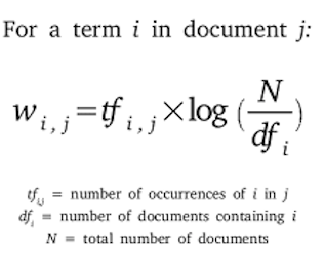

- In a nutshell TF-IDF works by pennalizing the common words in the corpus by assigning them lower weights while giving more importance to rarer words which are rare in the entire document corpus but appear good numbers in a few documents.

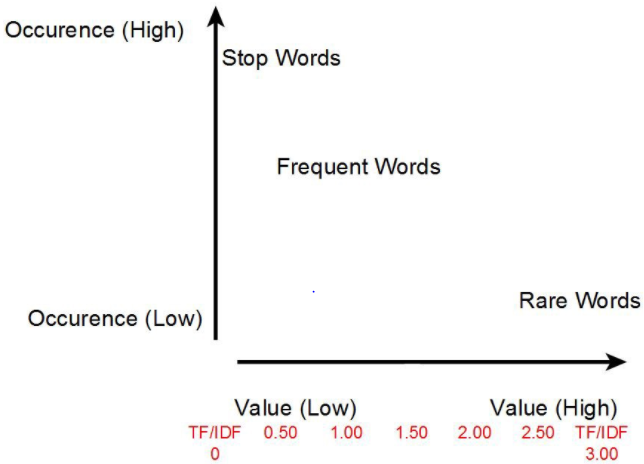

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(lowercase=True,stop_words=stop_words,analyzer='word',
                                       token_pattern=r'\w+',ngram_range=(1,2),min_df= 3,
                                       max_features=50000,use_idf=True, smooth_idf=True, sublinear_tf=True)
    train_tfidf = tfidf_vectorizer.fit_transform(data)
    return tfidf_vectorizer,train_tfidf

In [ ]:
#TFIDF Vectorized Data

tfidf_vectorizer,train_tfidf = tfidf(train_df.clean_text)

In [ ]:
print("Type of TFIDF count vectorizer :",type(train_tfidf))
print("Shape of TFIDF count vectorizer :",train_tfidf.get_shape())
print("Number of unique words including uni-grams and bi-grams  :", train_tfidf.get_shape()[1])

In [ ]:
# document wise TF-IDF score of each n-gram term that appears in the TFIDF transformed corpus

print(train_tfidf[0:2])

In [ ]:
print("some sample features(unique words) in the TF-IDF vectorized corpus :\n\n",tfidf_vectorizer.get_feature_names()[10000:10020])

In [ ]:
# Total TF-IDF score of each n-gram term that appears in the entire TFIDF transformed corpus 

list(zip(tfidf_vectorizer.get_feature_names()[10000:10020], train_tfidf.sum(0).getA1()[10000:10020]))

#### Get the vocabulary of TF-IDF embedding

- Vocabulary gives the mapping of words to feature indices.

In [ ]:
# Top words in TF_IDF embedding

print(dict(itertools.islice(tfidf_vectorizer.vocabulary_.items(), 25)))
#print(dict(list(tfidf_vectorizer.vocabulary_.items())[0: 25]) )

### Semantic Vectorization:

In this approach, numeric vectors are generated for each word considering the semantic meaning of the word in the   document corpus. These techniques represent a word with a low-dimensional vector (e.g. 100 dimensions). 
     
These techniques can be further divided into the 2 parts, static and dynamic embeddings. 

- **Static Word  Embeddings:**  Static means the same word will have same vector representation regardless of the context where it occurs.
**Examples** : Word2Vec, Glove, Fasttext.

- **Dynamic Word Embeddings:**   It considers the context of the word and the same word can have different vector representations based on the context where it occurs. Dynamic word embeddings also known as contextualized embeddings. **Examples** : BERT, GPT, ELMO, ULMFiT, etc.

    
Semantic embeddings rely on pretrained word vectors where a probabilistic score is attributed to each word in the corpus. These probabilities are plotted in a low dimensional plane and the "meaning" of the words are inferred from these vectors.

Several metrices can be applied on Words vectors, like finding similarity, distance measurement between the vectors, numerical transforms of the vectors.

With word vectors, we can specify semantic similarity between different words or collection of words. Generally, cosine distance is taken as the major metric of similarity measurement between word and sentence vectors to infer similarity.

#### In this kernel we will analyze only the static semantic embeddings.

### Static Semantic Embeddings

In this vectorization approach we will implement static embeddings using different techniques like:

1. Word2Vec
2. Glove
3. FastText

### **5.3 Converting the preprocessed text data to list**

This phase is helpful for investigating the individual word embeddings or sentence embeddings. Word based embeddings techniques requires a list of individual features(words) of each of the documents(sentences) of pre-processed 'text' data as input. Differentiating the individual rows of text makes it easier to pass into static and dynamic embedding models.

In [ ]:
list_of_sentances = list(train_df.clean_text.str.split())
print(f"First sentence : {list_of_sentances[0]}")

Let's closely analyze the cleaned_text. We will check the minimum and maximum number of words in a sentence.

In [ ]:
np.sort([len(sent) for sent in list_of_sentances])

We can see for our cleaned corpus, sentences lengths varies from a minimum of '0' words to a maximum of '6981' words. We can clearly observe that there is actually one record in the cleaned text with length '0', meaning there is not a single word present for that entry. Let's check the cleaned text for this record which has zero length.

In [ ]:
train_df.iloc[[[len(sent) for sent in list_of_sentances].index(0)]]

Since, such an input text has no meaning, semantically or otherwise, from the model building and evaluation standpoint, we will need to remove this entry from our input which we will be using for generating word/sentence embeddings.

In [ ]:
train_df.iloc[146131]

In [ ]:
train_df.drop([146131],axis=0,inplace=True)
train_df.reset_index(drop=True, inplace = True)

In [ ]:
list_of_sentances = [sent for sent in list_of_sentances if len(sent) > 0]

Since we have created such an input which is a list of lists of individual words each datapoint in the cleaned text, now let's start with building static semantic embeddings models like word2vec using Gensim library.

### **5.4 Word2Vec**

- Word2vec is actually a collection of two different methods: continuous bag-of-words (CBOW) and skip-gram. 

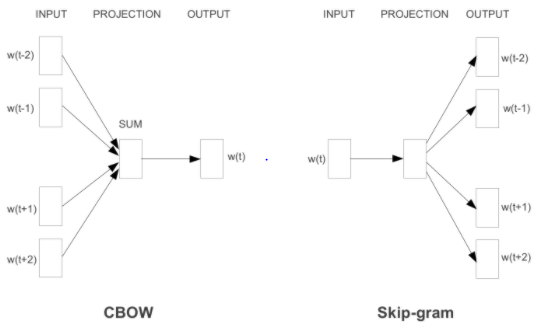

- Given a word in a sentence, CBOW uses the context or surrounding words as input for predicting the 'target word w(t)' (also called the center word) . For instance, if the context (sliding) window C is set to C=5, then the input would be words at positions w(t-2), w(t-1), w(t+1), and w(t+2). Basically the two words before and after the center word w(t). Given this information, CBOW then tries to predict the target word w(t).

- Skip-gram is the exact opposite. Instead of inputting the context words and predicting the center word, we feed in the center word and predict the context words. This means that w(t) becomes the input while w(t-2), w(t-1), w(t+1), and w(t+2) are the ideal output.

- Both the models (CBOW and Skip-gram) are focused on learning about words given their local usage context, where the context is defined by a window of neighboring words. This window is a configurable parameter of the model.

- The size of the sliding window has a strong effect on the resulting vector similarities. Large windows tend to produce more topical similarities, while smaller windows tend to produce more functional and syntactic similarities.

- Gensim provides a great way to use and start with Word2Vec. The Word2Vec algorithm can be built by using the Skipgram model as well as the Common Bag of Words Model. 

In [ ]:
# vectorize the words using Word2Vec skip-gram based

if os.path.isfile("../input/github-w2vec-300-trained/w2v_model.bin"):
    # load the Word2Vec model from saved Word2Vec model
    w2v_model = KeyedVectors.load("../input/github-w2vec-300-trained/w2v_model.bin")
    print("Trained 300-dim word2vec model:", w2v_model)
else:
    start_time = time.clock()
    w2v_model = Word2Vec(list_of_sentances,vector_size=300,window=8,min_count=5,workers=4,sg=1,hs=0,epochs=10)
    print("time required for Word2Vec model trainin :", time.clock() - start_time, "sec.")
    # save the modeled words produced from Word2Vec
    w2v_model.save('w2v_model.bin')

In [ ]:
list_of_words_w2v = list(w2v_model.wv.key_to_index)
print(f"Total number of words in trained word2vec : {len(list_of_words_w2v)}")
print(list_of_words_w2v[:50])

In [ ]:
# check for the top-10 most similar words 

print(w2v_model.wv.most_similar('useful',topn=10))
print('=='*50)
print(w2v_model.wv.most_similar('buggy', topn=10))

In [ ]:
#View the embedding vector for word 'buggy' and 'useful' using Word2Vec

print(w2v_model)
print(type(w2v_model))
# print("buggy:",w2v_model.wv['buggy'])
print("300-dim vector repreentation for word 'useful' using word2vec embeddings:\n",w2v_model.wv['useful'])

- these are the 300 dimensional word vectors using word2vec embeddings. 
- we can also observe that different word embedding techniques like glove and fasttext generates unique word vector the same words.

In [ ]:
#Measure Cosine distance

distance = w2v_model.wv.similarity('useful','buggy')
print(distance)

#### Inference:
- cosine similarity - ranges between 0 to 1,  0 being not similar and 1 being exactly similar
- word vectors for 'buggy' and 'useful' are not siimilar as the cosine similarity of these vectors is only 0.2.
- let's visulaize to confirm this observation.

In [ ]:
#plot the embedding vector for word 'buggy

plt.figure(figsize = (8,6))
plt.plot(w2v_model.wv['buggy'])
plt.plot(w2v_model.wv['useful'])
plt.show()

#### Inference:

- we can see that the vectors representations of words 'buggy' and 'useful' are non-overlapping and out of phase thus representing non-similar words.

#### Reducing the Dimensionality to Visualize the Word2Vec word vectors in 2D

- Transform the word2vec word vectors in 2D using T-SNE.
- Visualize the word2vec transfomred features in 2D.

In [ ]:
%%time

# Visualization of word2Vec embedded words in 2D using T-SNE transform  

tsne = TSNE(n_components=2, random_state=0)
w2v_data = w2v_model.wv[w2v_model.wv.key_to_index]
w2v_tsne_transformed = tsne.fit_transform(w2v_data[:100])

# create a scatter plot for projecting glove vetors in 2D

fig = px.scatter(x=w2v_tsne_transformed[:,0], y=w2v_tsne_transformed[:,1],text=list_of_words_w2v[:100])
fig.update_traces(textposition='bottom center')
fig.update_layout(
     width=1100,
    height=900,
    title_text='Visualization of Word2Vec embedded words in 2D using T-SNE transform'
)
fig.show()

#### Inferences:

- we can observe that the T-SNE approach has better summarized the data for high dimensional w2v vectors.
- we can also see word2vec has learned the local semantic relationship for the words.  
    - Example 1 -  words like 'expected' and 'behavior' are close to each other in the vector space.
    - Example 2 -  words like 'reproduce' and 'step' are close to each other in the vector space.
- thus we can conclude that the word2vec has capured the local semantic information for the word vectors based on the contextual information for the words.

### **5.5 Glove**


- The Global Vectors for Word Representation (GloVe), algorithm is an extension to the word2vec method for efficiently learning word vectors.

- Glove embeddings rely on global vector representations mechanism, which is an unsupervised algorithm. 

- The Global Vector (GloVe) model aims to combine the count-based matrix factorization and the context-based skip-gram model together.

- The GloVe approach combines both, the global statistics of matrix factorization techniques like LSA (Latent Semantic Analysis) and  the local context-based learning in word2vec.

- Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus. The result is a learning model that may result in generally better word embeddings.

- GloVe, is a global log-bilinear regression model for the unsupervised learning of word representations that outperforms other models on word analogy, word similarity, and named entity recognition tasks.

#### Glove algorithm implementation strategy:

- For implementing the Glove vectors, we will first load the pretrained glove vectors (100 - dimension representation) and convert these from "txt" format to Word2Vec format by using scripts provided in the Gensim library.
- This allows us to manipulate the glove embeddings in a manner similar to Word2Vec and apply the similarity metric.

In [ ]:
#load the pretrained 100-dim glove vector embeddings file and convert it into word2vec format598.


glove_pretrained_input = '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
glove_to_word2vec_converted = 'glove.6B.100d.txt.word2vec'

glove_loaded = glove2word2vec(glove_pretrained_input, glove_to_word2vec_converted)
print(glove_loaded)

In [ ]:
# load the word2vec formatted glove vector embeddings model

glove_model = KeyedVectors.load_word2vec_format(glove_to_word2vec_converted, binary=False)

In [ ]:
list_of_words_glove = list(glove_model.key_to_index)
print("Total number of words in trained glove embeddings :", len(list_of_words_glove))
print("\nThe top 50 words in glove_vectors:\n", list_of_words_glove[:50])

In [ ]:
# check for the top-10 most similar words using glove embeddings

print(glove_model.most_similar('useful',topn=10,))
print('='*50)
print(glove_model.most_similar('buggy', topn=10,))

#### Inference:

- since these are pre-trained word vectors using glove embeddings, the similar words for 'buggy' and 'useful'  are different compared to original word2vec

In [ ]:
#View the embedding vector for the words 'buggy' and 'useful' using glove embeddings

print(glove_model)
print(type(glove_model))
print("buggy:",glove_model['buggy'])
print("useful:",glove_model['useful'])

In [ ]:
# Measure cosine similarity for the words 'buggy' and 'useful' using glove embeddings

distance_g = glove_model.similarity('useful','buggy')
print(distance_g)

#### Inference:
- As expected, words 'useful' and 'buggy' are not similar at all.

In [ ]:
#plot the embedding vectors for the words 'buggy' and 'useful' using glove embeddings

plt.figure(figsize = (8,6))
plt.plot(glove_model['buggy'])
plt.plot(glove_model['useful'])
plt.show()

#### Inference:

- we can see that the vectors representations of words 'buggy' and 'useful' are non-overlapping and out of phase thus representing non-similar words.

#### Reducing the Dimensionality to Visualize the Glove word vectors in 2D

In [ ]:
%%time

# Visualization of glove embedded words in 2D using T-SNE transform  

tsne = TSNE(n_components=2, random_state=0)
glove_data = glove_model[glove_model.key_to_index]
glove_tsne_transformed = tsne.fit_transform(glove_data[:200])

# create a scatter plot for projecting glove vetors in 2D
fig = px.scatter(x=glove_tsne_transformed[:,0], y=glove_tsne_transformed[:,1],text=list_of_words_glove[:200])
fig.update_traces(textposition='bottom center')
fig.update_layout(
     width=1100,
    height=900,
    title_text='Visualization of glove embedded words in 2D using T-SNE transform'
)
fig.show()

#### Inferences:

- We can observe that the T-SNE approach has better summarized the data for 100 dimensional Glove vectors. 
- We can see related words like 'former'-'president', 'governement'-'minister'-'party' are placed closed to each other in vector space.
- We can also see Glove has learned the global and local semantic relationship for the words. 
  - Example -  words like 'united'-'states', 'new'-'york' resides in the same region.
  - Example -  all the days like 'monday', 'tuesday',etc. resides in the same region.
  
- Thus we can conclude that the Glvoe has capured the local as well as global semantic information for the word vectors based on the contextual information for the words.

### **5.6 FastText**

- Word2vec treats each word in corpus like an atomic entity and generates a vector for each word. In this sense Word2vec is very much like Glove - both treat words as the smallest unit to train on.
- Fasttext (which is essentially an extension of word2vec model), treats each word as composed of character ngrams. 
- So the vector for a word is made of the sum of this character n grams. For example, the word vector “apple” is a sum of the vectors of the n-grams “<ap”, “app”, ”appl”, ”apple”, ”apple>”, “ppl”, “pple”, ”pple>”, “ple”, ”ple>”, ”le>” (assuming hyperparameters for smallest ngram (min_n = 3) and largest ngram (max_n = 6) ).
- Some of the advantages offered by FastText compared to the Word2Vec and Glove are as follows:
    1. FasteText Generate better word embeddings for rare words ( even if words are rare their character n-grams are still shared with other words - hence the embeddings can still be good).
    2. Out of vocabulary words - FastText can construct the vector for a word from its character n-grams even if word doesn't appear in training corpus. Both Word2vec and Glove don't support this.


In this case we will train the FastText model from Gensim using the corpus specific to our problem. We can also use the pre-trained FastText model for evaluating performance on our corpa.

In [ ]:
# vectorize the words using FastText skip-gram based
if os.path.isfile("../input/fasttext300trained/fasttext_model.bin"):
    # load the model from saved fasttext model
    fasttext_model = KeyedVectors.load("../input/fasttext300trained/fasttext_model.bin")
    print("Pre-trained 300-dim fasttext model:",fasttext_model)
else:
    start_time = time.clock()
    fasttext_model = FastText(list_of_sentances,vector_size=300,window=8,min_count=5,workers=4,sg=1,hs=0,epochs=20)
    print("time required for FastText model training :", time.clock() - start_time, "sec.")
    # save the modeled words produced from fasttext
    fasttext_model.save('github_fasttext_300_model.bin')

In [ ]:
list_of_words_fasttext = list(fasttext_model.wv.key_to_index)
print("Total number of words in trained fasttext embeddings :", len(list_of_words_fasttext))
print("\nThe top 50 words in fasttext_vectors:\n", list_of_words_fasttext[:50])

In [ ]:
# check for the top-10 most similar words using fasttext embeddings

print(fasttext_model.wv.most_similar('useful',topn=10,))
print('='*50)
print(fasttext_model.wv.most_similar('buggy', topn=10,))

Since these are the pre-trained word vectors using fasttext embeddings, few of the similar words for 'buggy' and 'useful'  are different compared to word2vec.

In [ ]:
#View the embedding vector for the words 'buggy' and 'useful' using fasttext embeddings

print(fasttext_model)
print(type(fasttext_model))
# print("buggy:",fasttext_model.wv['buggy'])
# print("useful:",fasttext_model.wv['useful'])
print("300-dim vector repreentation for word 'useful' using fasttext embeddings:\n",fasttext_model.wv['useful'])

In [ ]:
# Measure cosine similarity for the words 'buggy' and 'useful' using fasttext embeddings

distance_g = fasttext_model.wv.similarity('useful','buggy')
print(distance_g)

#### Inference:
- As expected, words 'useful' and 'buggy' are not similar at all.

In [ ]:
#plot the embedding vectors for the words 'buggy' and 'useful' using fasttext embeddings

plt.figure(figsize = (8,6))
plt.plot(fasttext_model.wv['buggy'])
plt.plot(fasttext_model.wv['useful'])
plt.show()

#### Inference:

- we can see that the vectors representations of words 'buggy' and 'useful' are non-overlapping and out of phase thus representing non-similar words.

## Reducing the Dimensionality to Visualize the FastText word vectors in 2D

- Transform the fasttext word vectors in 2D using T-SNE.

In [ ]:
%%time

# Visualization of glove embedded words in 2D using T-SNE transform  

tsne = TSNE(n_components=2, random_state=0)
fasttext_data = fasttext_model.wv[fasttext_model.wv.key_to_index]
fasttext_tsne_transformed = tsne.fit_transform(fasttext_data[:200])

# create a scatter plot for projecting fasttext vetors in 2D
fig = px.scatter(x=fasttext_tsne_transformed[:,0], y=fasttext_tsne_transformed[:,1],text=list_of_words_fasttext[:200])
fig.update_traces(textposition='bottom center')
fig.update_layout(
     width=1100,
    height=900,
    title_text='Visualization of fasttext embedded words in 2D using T-SNE transform'
)
fig.show()

### Inferences:

- Due to the character level n-gram approach, we can observe that the t-SNE has better approximated the word vectors and all the words are placed closed to each other in vector space.
- We can also see that FastText has learned the semantic relationship for the words very well. 
  - Example -  words like 'application'-'app'-'android', 'actual'-'expected'-'behavior' etc. resides in the vicinity of each other in the vector space.
- Thus we can conclude that the FastText has capured the semantic information for the word vectors at the granular levels based on the contextual information of the words in our corpus.

## **6. Defining methods for Document to Vector conversion and Statistical Modelling and Evaluation**

- In this part, we will define methods for converting individual word embeddings to sentence embeddings and for evaluating our data using different statistical models.

### **6.1 Word Vectors to Sentence conversion using average word2vec embedding**

In [ ]:
def avg_w2v_embeddings(data,model):
  
    # create a sent vector of size 300 as our word2vec model is trained with a vect_size of 300
    sent_vec = np.zeros(300)
    
    # num of words present in each sentence having a valid vector present in the word2vec vocab
    cnt_words =0; 
    
    # loop through each word in a sentence
    for word in (data.split()):
        # check if the word is present in the word2vec vocab, if yes then append its vector representation to sent_Vec array
        if word in model.wv.key_to_index:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1

    # check if the count of words is not zero
    if cnt_words != 0:
        sent_vec /= cnt_words
    
    return sent_vec

In [ ]:
start_time = time.clock()
train_df['Vectorized_avg_w2v'] = train_df['clean_text'].apply(avg_w2v_embeddings, model=w2v_model)
print(f"Time required for average word2vec : {time.clock() - start_time}")
#train_df.to_csv('Avg-W2V-Baseline.csv',index=True)

### **6.2 Word Vectors to Sentence conversion using Tf-Idf weighted word2vec embeddings**

In [ ]:
def tfidf_w2v_embeddings(data,model,idf_dict,tfidf_feat):
    
    # create a sent vector of size 300 as our word2vec model is trained with a vect_size of 300
    sent_vec = np.zeros(300)
    
    # sum of tfidf values for words present in each sentence
    weight_sum =0
    # loop through each word in a sentence
    for word in data.split():
        # check if the word is present in the word2vec vocab and in the tf-idf vocab
        if word in model.wv.key_to_index and word in tfidf_feat:
            w2v_vec = model.wv[word]

            # to reduce the tf-idf computation we are computing as follows
            # (data.split().count(word)/len(data.split())) = tf value of word in this sentence
            # tfidf_dict[word] = idf value of word in whole courpus
            tf_idf = (data.split().count(word)/len(data.split())) * idf_dict[word]
            
            sent_vec += (w2v_vec * tf_idf)
            weight_sum += tf_idf
    
    if weight_sum != 0:
        sent_vec /= weight_sum
    
    return sent_vec

In [ ]:
start_time = time.clock()
# train a tf-idf model on cleaned text data
tf_idf_vect = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,1), lowercase=True, analyzer='word', token_pattern=r'\w+', 
                               min_df= 1, use_idf=True, smooth_idf=True, sublinear_tf=True)

# fit the tf-idf model on the cleaned text data
tf_idf_vect.fit(train_df.clean_text)

# create a dictionary with word as a key, and the idf as a value
idf_dictonary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tf-idf features
tfidf_featues = tf_idf_vect.get_feature_names()

train_df['Vectorized_tfidf_w2v'] = train_df['clean_text'].apply(tfidf_w2v_embeddings, model=w2v_model, idf_dict=idf_dictonary, tfidf_feat=tfidf_featues)
print(f"Time required for tf-idf word2vec : {time.clock() - start_time}")
#train_df.to_csv('TfIdf-W2V-Baseline.csv',index=False)

### **6.3 Statistical Models Building and Evaluation using word2vec embeddings**

In this part, we will use different statistical models for evaluating the performance of the of our word2vec embeddings. Increasing the number of different models increases the time complexity of the model evaluation method here. Thus I have used only few methods for model evaluation here for demonstration purpose. Based on your requirement you can use different statistical models for evaluation.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
def model_evaluate(train_x,train_y,test_x,test_y,emb_name,scoring,scoring_param,scoring_method):
    """
    train_x,train_y = train input and output
    test_x,test_y = test input and output
    emb_name = 'Word2Vec'
    scoring = 'roc_auc_ovr'
    scoring_param ='AUC'
    scoring_method ='roc_auc_score'
    """
    
    models=[]
    model_name = []
    model_training_result = []
    model_validation_result = []
    
    models.append(('LogisticRregression',LogisticRegression(C=1.0, penalty='l2',class_weight='balanced')))
#     models.append(('SVM',SGDClassifier(alpha=0.001, penalty='l2', loss='hinge',class_weight='balanced',random_state=42)))
    models.append(('ExtraTreesClassifier',ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2,random_state=42)))
    models.append(('BagClassifier',BaggingClassifier(DecisionTreeClassifier(criterion='gini'),max_samples=0.5, max_features=0.5,random_state=42)))
#     models.append(('GradientBoostClassifier',GradientBoostingClassifier(learning_rate=1e-2, loss='deviance',n_estimators=100,random_state=42)))
#     models.append(('AdaBoostClassifier',AdaBoostClassifier(learning_rate=1e-2,algorithm='SAMME.R',n_estimators=50,random_state=42)))
#     models.append(('XGBoosting',xgb(n_estimators=50,max_depth=5,objective='multi:softmax',num_class=3,booster='gbtree',random_state=42,n_jobs=-1)))
    models.append(('LightGBM',lgbm(n_estimators=500,boosting_type='gbdt',class_weight='balanced',random_state=42,n_jobs=-1)))

    print(f"Statistical Models Evaluation using {emb_name} Baseline")

    for name, model in tqdm(models):
        
#         if name == "SVM":
#             model_svm = model.fit(np.vstack(train_x),train_y)
#             model = CalibratedClassifierCV(cv="prefit",method="sigmoid",base_estimator=model_svm)
        
        skfold=StratifiedKFold(n_splits=6, shuffle=True, random_state=42)       
        results = cross_val_score(model, np.vstack(train_x), train_y, cv=skfold, scoring = scoring)
        print("======================="*4)
        print(f"Classifier: {name} has a training {scoring_param} score of {round(results.mean(), 3)}")
        model_training_result.append(results.mean())
        
        predictions = cross_val_predict(estimator = model, X = np.vstack(test_x), y = test_y, method = 'predict_proba')
        pred_score = scoring_method(y_true=test_y, y_score=predictions, average='weighted', multi_class='ovr')
        model_validation_result.append(pred_score)
        model_name.append(name)

    final_outcomes = pd.DataFrame(columns=['Embeddings_Baseline','Model',f'Training_{scoring_param}_Score',f'Validation_{scoring_param}_Score'])
    final_outcomes['Embeddings_Baseline'] = [emb_name]*len(model_training_result)
    final_outcomes['Model'] = model_name
    final_outcomes[f'Training_{scoring_param}_Score'] = model_training_result
    final_outcomes[f'Validation_{scoring_param}_Score'] = model_validation_result
    return final_outcomes

## **7. Model Building and Evaluation**

- In this part, we will build statistical models using the word2vec embeddings that we have trained on our local corpus and evaluate the models using 'auc_score'.

### **7.1. Model Building and Evaluation using Average Word2Vec on trained corpus**

In [ ]:
#Split the dataset into training and test sets
y = train_df['label'].values
X = train_df['Vectorized_avg_w2v'].values
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42)
train_x.shape,train_y.shape,test_x.shape,test_y.shape
len(train_x), len(train_y), len(test_x), len(test_y)

Result_df = pd.DataFrame(columns=['Embeddings_Baseline','Model','Training_AUC_Score','Validation_AUC_Score'])
start_time = time.clock()
Result_df = model_evaluate(train_x,train_y,test_x,test_y,'Word2Vec','roc_auc_ovr','AUC',roc_auc_score)
print(f"Time required for avg word2vec modelling and evaluation : {time.clock() - start_time}")
Result_df

We can observe that "Lght Gradient Boosting" has outperformed compared to other modeling methods. We can hyperparameter tuning and feature selection to further improve the performance.

### 7.2. Model Building and Evaluation using Tf-Idf weighted Word2Vec on trained corpus

In [ ]:
#Split the dataset into training and test sets

y = list(train_df['label'].values)
X = list(train_df['Vectorized_tfidf_w2v'].values)
train_x_tfidfw2v, test_x_tfidfw2v, train_y_tfidfw2v, test_y_tfidfw2v = train_test_split(X,y,test_size=0.2,random_state=42)
#train_x_tfidfw2v.shape,train_y_tfidfw2v.shape,test_x_tfidfw2v.shape,test_y_tfidfw2v.shape
len(train_x_tfidfw2v), len(train_y_tfidfw2v), len(test_x_tfidfw2v), len(test_y_tfidfw2v)


Result_df = pd.DataFrame(columns=['Embeddings_Baseline','Model','Training_AUC_Score','Validation_AUC_Score'])
start_time = time.clock()
Result_df = model_evaluate(train_x_tfidfw2v,train_y_tfidfw2v,test_x_tfidfw2v,test_y_tfidfw2v,'Word2Vec','roc_auc_ovr','AUC',roc_auc_score)
print(f"Time required for avg word2vec modelling and evaluation : {time.clock() - start_time}")
Result_df

## **8.Model Building and Evaluation using Neural Network LSTM based model**

In this approach, I will use our trained Word2Vec model for generating embedding layer for Neural Network architecture. In this implementation, I will use the bi-directional LSTM layers to model the order of words in our sequence in both the directions.

Before we move to modelling let's understand some statistics about our list of sentences. This will be useful for generating the embeddings matrix.

In [ ]:
num_of_words_in_seq = np.sort([len(sent) for sent in list_of_sentances])

sns.distplot(num_of_words_in_seq, bins = 30)

In [ ]:
max_sent_length = np.max(np.sort([len(sent) for sent in list_of_sentances]))
print(f"Maximum number of words in sequence post cleanup : {max_sent_length}")
min_sent_length = np.min(np.sort([len(sent) for sent in list_of_sentances]))
print(f"Minimum number of words in sequence post cleanup : {min_sent_length}")
avg_sent_length = np.mean(np.sort([len(sent) for sent in list_of_sentances]))
print(f"Average length of the number of words in a sequence post cleanup : {avg_sent_length}")
median_sent_length = np.median(np.sort([len(sent) for sent in list_of_sentances]))
print(f"Median length of the number of words in sequence post cleanup : {median_sent_length}")

Thus I will take the sequence max_length as 50 for text to sequence conversion.

In [ ]:
## tokenize text
tokenizer = KP.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(list_of_sentances)
vocab_dict = tokenizer.word_index

Let's check the vocabulary post tokenization

In [ ]:
print(dict(list(vocab_dict.items())[0:10]))
print("Total length of vocabulary:", len(list(vocab_dict.items())))

Let's create tokenized sequences from our list of sentences.

In [ ]:
text_seq = tokenizer.texts_to_sequences(list_of_sentances)

Now we will pad our list of text sequences with zeros's and max padding length of 50 such all of sequences of same size.

In [ ]:
seq_corpus = KP.sequence.pad_sequences(text_seq, maxlen=50, padding="post", truncating="post")

Next, we will create train and test datasets from the sequence corpus.

In [ ]:
#Split the dataset into training and test sets
y = train_df['label'].values
X = seq_corpus
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
train_x.shape,train_y.shape,test_x.shape,test_y.shape
len(train_x), len(train_y), len(test_x), len(test_y)

Convert class labels to binary class matrices.

In [ ]:
train_y = keras.utils.to_categorical(train_y, 3)
test_y_conv = keras.utils.to_categorical(test_y, 3)

As we have created the train and test datasets, now we will need to create an embeddings matrix that we will use as weight matrix in our neural network architecture. 

In [ ]:
## create an embeddings matrix (length of vocabulary x vector size) and initialize with all 0s
embeddings_mat = np.zeros((len(vocab_dict)+1, 300))

for word,idx in vocab_dict.items():
    ## update the row with vector
    try:
        embeddings_mat[idx] =  w2v_model.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
print(f"Shape of Embeddings Matrix: {embeddings_mat.shape}")

Next up we will train a model using bi-directional LSTM's and evaluate it using test set.

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim=embeddings_mat.shape[0], output_dim=embeddings_mat.shape[1],weights=[embeddings_mat], input_length=50, trainable=False))
model.add(layers.Bidirectional(layers.LSTM(units=50,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(units=50)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy','AUC'])
print(model.summary())

In [ ]:
## train
training = model.fit(x=train_x, y=train_y, batch_size=128, epochs=20, shuffle=True, verbose=1, validation_split=0.2)

we can observe that as the number of epochs are increasing, the validation score is decreasing but the training score is increasing. This means the model is fitting on the train data. This problem can be solved by adding dropout layers in our architecture.

In [ ]:
score = model.evaluate(test_x, test_y_conv, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)
print('Test auc:', score[2])

At last, let's plot the confustion matrix and classifcation report to check the model performance.

In [ ]:
## test
predicted_prob = model.predict(test_x)
predicted = [np.argmax(pred) for pred in predicted_prob]

In [ ]:
print("Confusion Matrix :")
sns.heatmap(confusion_matrix(y_true = test_y, y_pred = predicted), cmap='BuPu', annot=True, linewidths=1,fmt='1g')

In [ ]:
print("Clssification Report:")
print(classification_report(y_true = test_y, y_pred = predicted))

## **9. Conclusion**

This work demonstrates the application of different statistical methods for evaluating performance of our Word2Vec implementaion. In this kernel I have implemented end-to-end model evaluation using the "Word2Vec" static semantic embeddings. I have also demonstrated other static semantic embeddings strategies like "Glove" and "FastText" and non-semantic embeddings strategies like "BOW" and "Tf-Idf". 
I have carried our the word vectors to sentence conversion using "Averaging or Mean pooling" the word vectors. The word vectors to sentence conversion is also demonstrated using the "Tf-IDF weighted Word2Vec" strategy, based on the use case and application one can choose to implement any one of the two methods. The same word to sentence conversion methods which are used for Word2Vec in this implementation can be extended to the "Glove" and "FastText" embeddings.
At last, I have trained and evaluated a LSTM based neural networks model using the Word2Vec embeddings and evaluated the model performance.


<h3 style="text-align:center;color:red"><b>if you like this work, please do an upvote</b></h3>